# Bootstrap chainladder model

Now we will explore the properties and methods underlying the Munich Chainladder class.

As usual, we we import the chainladder package as well as the popular pandas and numpy package. For plotting purposes, we will also be using Jupyter’s `%matplotlib inline` magic function to render the plots.

In this tutorial we will use industry data from the [LOSS RESERVING DATA PULLED FROM NAIC SCHEDULE P](http://www.casact.org/research/index.cfm?fa=loss_reserves_data)

In [1]:
import chainladder as cl
import pandas as pd
import numpy as np
%matplotlib inline

C:\Users\jboga\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Import the data
The CAS Loss Reserving incurred data is schedule P data and would include include IBNR.  Additionally, the database includes the completed triangles (i.e. the latest accident year has valuations at age 10 years).  We will focus on Workers' Compensation data.

We will:
 - Read in the data
 - Devlop a case incurred metric
 - Summarize data across all carriers
 - Retain age 10 actual case incurred
 - Eliminate known data beyond year end of 1997

In [2]:
# Read in the data
CAS = pd.read_csv(r'http://www.casact.org/research/reserve_data/wkcomp_pos.csv')
# Devlop a case incurred metric
CAS['INC_LOSS'] = CAS['IncurLoss_D']-CAS['BulkLoss_D']
# Summarize data across all carriers
WCTri = pd.pivot_table(data=CAS, values='INC_LOSS', index=['AccidentYear'],columns=['DevelopmentLag'], aggfunc=np.sum)
WCTri.columns = [str(item) for item in WCTri.columns]
# Retain age 10 actual case incurred
Ult10_values = WCTri.iloc[:,-1]
# Eliminate known data beyond year end of 1997
WCTri=pd.DataFrame(np.array(WCTri)*np.array([np.append(np.array([1]*(len(WCTri)-i)),np.array([np.nan]*i)) for i in range(len(WCTri))]),
                   index = WCTri.index, columns=WCTri.columns)

### Plot the triangle

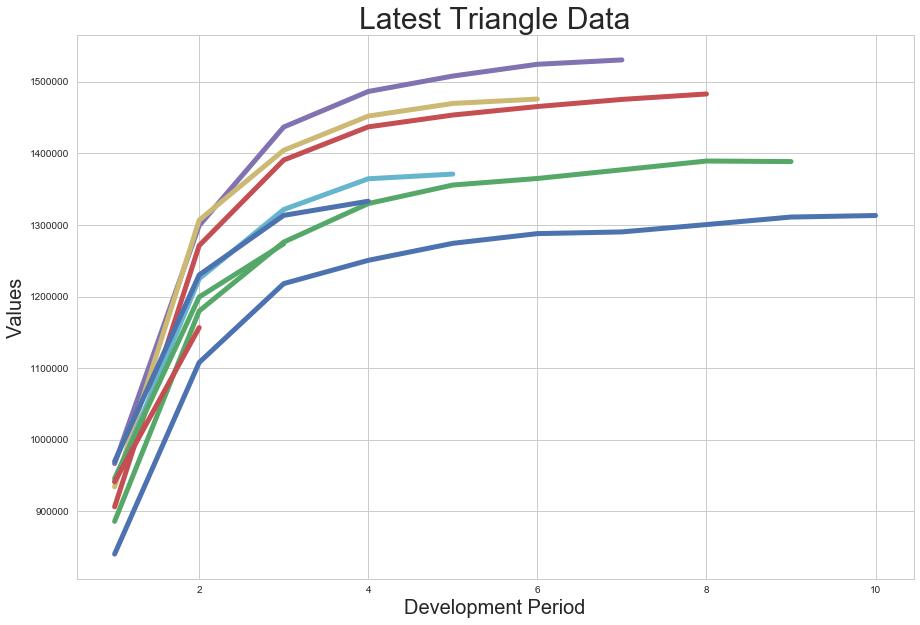

In [3]:
cl.Triangle(WCTri).plot()

### Generate bootstrap chainladder model

In [4]:
BS = cl.BootChainladder(WCTri, n_sims=50000)

The bootstrap model plots provide various diagnotics to enable a better understanding of the distribution of carried IBNR. 

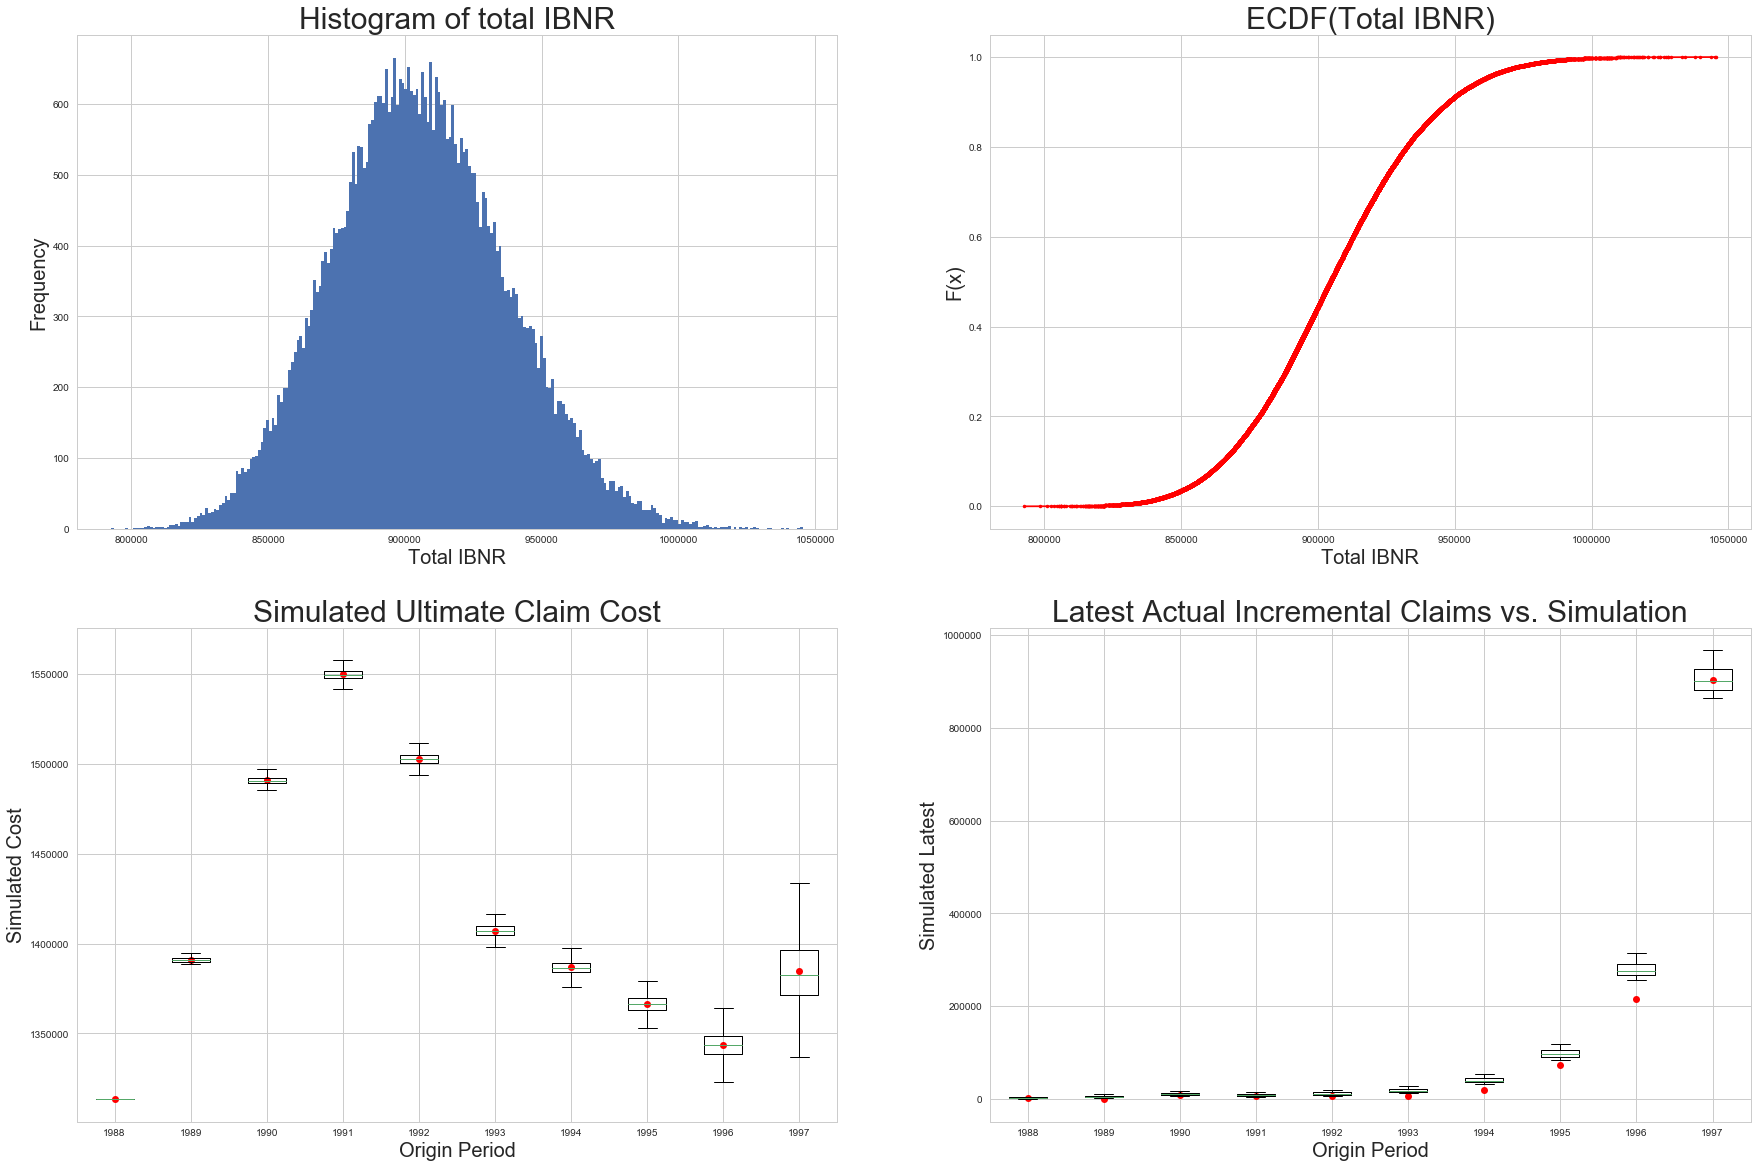

In [5]:
BS.plot()

### Verify results

We should expect enough credibility/stability in industrywide data that the Chainladder method is a reasonably good model for developing the triangle.  We will use the Bootstrap mean ultimates to test this.  As the Bootstrap model was fit without a tail, the ultimate represents age 10 Expected Incurred amount).

In [6]:
print('Case Incurred Actual vs Bootstrap Expected gap at age 10 is ' 
      + str(round(np.sum(Ult10_values - BS.summary()['Mean Ultimate'].round(0))/np.sum(Ult10_values)*100,2))
      +'% of total case inurred at age 10')
(Ult10_values - BS.summary()['Mean Ultimate'].round(0))/Ult10_values

Case Incurred Actual vs Bootstrap Expected gap at age 10 is 0.35% of total case inurred at age 10


AccidentYear
1988    0.000000
1989    0.003530
1990    0.005079
1991    0.004924
1992    0.011556
1993    0.003511
1994    0.018668
1995    0.009370
1996    0.000478
1997   -0.024221
dtype: float64